In [1]:
# Import Modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
import statistics
import fastcluster
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations
from itertools import permutations
from scipy.spatial.distance import pdist, squareform
from mpl_toolkits.mplot3d import Axes3D

In [2]:
from sklearn.datasets import fetch_openml

# Fetch openML parser
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
mnist.target = mnist.target.astype(np.int64) # or you can use int
data_mnist = mnist.data

# convert to Pandas DataFrame
mnist_target_df = pd.DataFrame(mnist.target)
mnist_target_df = mnist_target_df.rename(columns={0: 'label'})
data_mnist_df = pd.DataFrame(data_mnist)

# Min-Max Scaling of mnist.data
scaler = MinMaxScaler(feature_range=(0, 1))
x = pd.DataFrame(scaler.fit_transform(data_mnist_df))

# Combine target & data. Print the new dataset for use. 
x_comb = pd.concat([mnist_target_df, x], axis=1)
print(f'\n----> SCALED DATASET : \n\n{x_comb}')
s_row, s_col = x.shape
print(f'\n*\tSamples : {s_row}, Dimensions : {len(x_comb.columns)}')


----> SCALED DATASET : 

       label    0    1    2    3    4    5    6    7    8  ...  774  775  776  \
0          5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1          0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2          4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3          1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4          9  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
69995      2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
69996      3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
69997      4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
69998      5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
69999      6  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

 

In [8]:
# Decomposition

# Calculate the co-variance matrix
cov_matrix = np.cov(x.T)

# Don't use SVD for decomposition, use linalg
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Sort the eigenvalues and eigenvectors in descending order
idx = eigenvalues.argsort()[::-1]   
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

# Print the sorted eigenvalues and eigenvectors
print("Eigenvalues:")
print(eigenvalues)
print("\nEigenvectors:")
print(eigenvectors)

eig_vals_total = sum(eigenvalues)
explained_variance = [(i / eig_vals_total)*100 for i in eigenvalues]
explained_variance = np.round(explained_variance, 2)
cum_explained_variance = np.cumsum(explained_variance)
print('\nExplained variance             : {}'.format(explained_variance))

print('Cumulative explained variance  : {}'.format(cum_explained_variance))

Eigenvalues:
[ 5.14100828e+00+0.00000000e+00j  3.77444725e+00+0.00000000e+00j
  3.24383486e+00+0.00000000e+00j  2.85024785e+00+0.00000000e+00j
  2.57887853e+00+0.00000000e+00j  2.27097733e+00+0.00000000e+00j
  1.72926016e+00+0.00000000e+00j  1.52426600e+00+0.00000000e+00j
  1.45501796e+00+0.00000000e+00j  1.23546267e+00+0.00000000e+00j
  1.11126357e+00+0.00000000e+00j  1.07479521e+00+0.00000000e+00j
  9.00464626e-01+0.00000000e+00j  8.93583757e-01+0.00000000e+00j
  8.35223139e-01+0.00000000e+00j  7.84036776e-01+0.00000000e+00j
  6.95952446e-01+0.00000000e+00j  6.74671327e-01+0.00000000e+00j
  6.26278009e-01+0.00000000e+00j  6.08166138e-01+0.00000000e+00j
  5.62328637e-01+0.00000000e+00j  5.32659560e-01+0.00000000e+00j
  5.05945670e-01+0.00000000e+00j  4.79826254e-01+0.00000000e+00j
  4.65927700e-01+0.00000000e+00j  4.42470823e-01+0.00000000e+00j
  4.27180706e-01+0.00000000e+00j  4.14460772e-01+0.00000000e+00j
  3.90483238e-01+0.00000000e+00j  3.63977773e-01+0.00000000e+00j
  3.46111460

In [9]:
# Data Transformation.

# Select 'k' no of eigen vectors
k = 60
W = eigenvectors[:, :k] # Projection matrix

# Transform the original dataset
X_proj = x.dot(W)
X_proj = X_proj.applymap(np.real)
X_proj = X_proj.round(2)
X_proj_fin = pd.concat([mnist_target_df, X_proj], axis=1)
print('\nNew projection:')
print(X_proj_fin)


New projection:
       label     0     1     2     3     4     5     6     7     8  ...    50  \
0          5  3.47 -1.31  0.51 -4.11 -3.44  0.55  2.89 -0.46  0.22  ...  0.23   
1          0  6.95 -1.21  2.97 -3.83 -0.33  0.27  1.78  0.69  1.76  ...  0.97   
2          4  2.76  1.48  0.08  0.15 -2.40 -0.33 -1.41 -1.18  1.32  ... -0.03   
3          1 -0.13 -2.45  1.87 -1.50 -3.73 -3.03  0.11  0.68  2.80  ... -0.44   
4          9  1.46  2.79  0.77 -2.88 -4.02 -0.44  1.63  1.92  2.41  ...  0.57   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
69995      2  4.19 -2.22  0.62 -0.84 -6.96 -3.93  5.04 -0.80 -0.52  ...  0.01   
69996      3  5.22 -2.81 -2.56 -2.55 -4.00  0.45  4.61 -2.79  1.44  ...  0.11   
69997      4  1.93  2.25  2.05 -3.63 -6.27 -0.85  1.82  1.64  1.42  ... -0.24   
69998      5  1.77 -0.53  3.20 -3.04 -3.02  0.78  2.58 -0.28  2.74  ... -0.65   
69999      6  7.14 -0.40  3.58  1.17 -4.33  2.48  3.87  1.94  2.18  ... -0.37   

         5

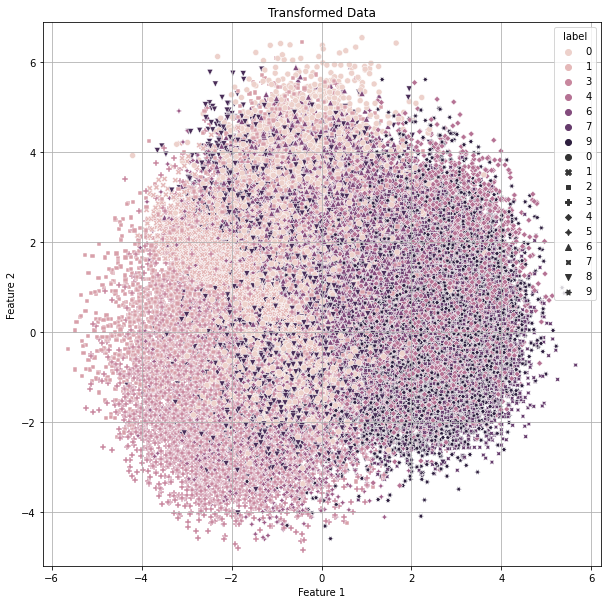

In [6]:
# Calculate the end points of the PC axes (scaled by the square root of the absolute eigenvalues)
pc_endpoints = eigenvectors * np.sqrt(np.abs(eigenvalues))
  
def Original():
    
    # Set the figure size
    plt.figure(figsize=(10, 10))

    df = pd.DataFrame(X_proj_fin)

    # Plot the DataFrame using Seaborn's scatterplot function
    sns.scatterplot(x=X_proj_fin[1], y=X_proj_fin[2],hue = X_proj_fin['label'], style=X_proj_fin['label'], data=df)

    # Show the plot
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Transformed Data')
    plt.grid(True)
    plt.axis('equal')
    plt.show()
    

Original()
#Transformed()

In [7]:
X_proj_1D = X_proj.to_numpy()
#X_proj_1D = X_proj.flatten()[::-1]

# Calculate the condensed distance matrix
condensed_dist_matrix = pdist(X_proj_1D)

# Convert the condensed distance matrix to a square distance matrix
dist_matrix = pd.DataFrame(squareform(condensed_dist_matrix))

MemoryError: Unable to allocate 36.5 GiB for an array with shape (70000, 70000) and data type float64

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(dist_matrix, cmap='Greys', annot=False, annot_kws={"size": 10})

title_fontsize = 5
label_fontsize = 5

plt.title('Heatmap', fontsize=title_fontsize)
plt.xlabel('Projection - X axis', fontsize=label_fontsize)
plt.ylabel('Projection - Y axis', fontsize=label_fontsize)

ax = plt.gca()
ax.tick_params(axis='x', labelsize=label_fontsize)
ax.tick_params(axis='y', labelsize=label_fontsize)

plt.show()

In [ ]:
# Create a custom color mapping based on the species
species_color_mapping = X_proj_fin['Wine'].map({1: 'blue', 2: 'orange', 3: 'green'})
# Plot the distance matrix heatmap with colored labels
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(dist_matrix, cmap='viridis', ax=ax,
            cbar_kws={'label': 'Distance'})

# Set the tick labels and colors
ax.set_xticks(np.arange(dist_matrix.shape[0]) + 0.5)
ax.set_yticks(np.arange(dist_matrix.shape[0]) + 0.5)
ax.set_xticklabels(species_color_mapping.index, rotation=90, fontsize=6)
ax.set_yticklabels(species_color_mapping.index, rotation=0, fontsize=6)

# Color the tick labels
for tick, color in zip(ax.get_xticklabels(), species_color_mapping):
    tick.set_color(color)

for tick, color in zip(ax.get_yticklabels(), species_color_mapping):
    tick.set_color(color)

# Show the plot
plt.title('Distance Matrix Heatmap with Colored Labels')
plt.show()

In [ ]:
# Dump to CSV

dist_matrix.to_csv('PCA_MEAN_3_dim.csv', index=False)